In [2]:
import os
from dotenv import load_dotenv

# Load .env file
load_dotenv()

OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

In [3]:
from datasets import load_dataset

ds = load_dataset("HuggingFaceM4/ChartQA")

/Users/armintalaie/miniconda3/envs/nlpviz/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_ds = ds["train"]
cols = train_ds.column_names
print(cols)

['image', 'query', 'label', 'human_or_machine']


In [5]:
from datasets import Image
train_ds = train_ds.cast_column("image", Image(decode=False))

# Then try to look at the raw data
first_item = train_ds[0]
# Print everything except the image data
print({k: v for k, v in first_item.items() if k != 'image'})

# Let's also check the type of the image data
print("Image data type:", type(first_item['image']))

{'query': 'Is the value of Favorable 38 in 2015?', 'label': ['Yes'], 'human_or_machine': 0}
Image data type: <class 'dict'>


Is the value of Favorable 38 in 2015?
['Yes']


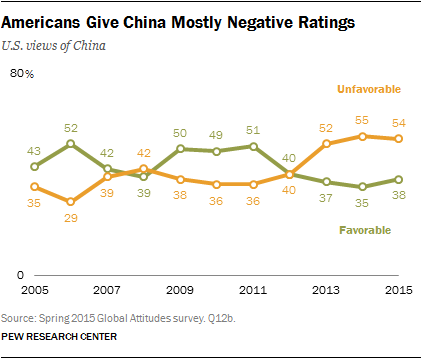

In [6]:
from PIL import Image
import io

img_data = train_ds[0]['image']['bytes']
img = Image.open(io.BytesIO(img_data))
print(train_ds[0]['query'])
print(train_ds[0]['label'])
display(img)  

In [7]:

def get_image_dimensions(row):
    img_data = row['image']['bytes']
    img = Image.open(io.BytesIO(img_data))
    return img.size

print(get_image_dimensions(train_ds[0]))

(422, 359)


In [62]:
from pydantic import BaseModel

class Coordinates(BaseModel):
    x: int
    y: int
    weight: int

class Output(BaseModel):
    raw_answer: str
    coordinates: list[Coordinates]
    
primer_query: str = """You will be given an image of chart, its width and height, and a question. Answer the question based on the chart; for any part of the image you refer to, include the width and height of the part you are referring to and explain your reasoning. 
For the question you will make a list of coordinates that correspond to the answer. Each coordinate will have an x and y value, and a weight. The weight is a number between 0 and 1 that represents the confidence of the model in the answer. The sum of the weights should be 1.
Top left corner of the image is (0, 0) and the bottom right corner is (width, height). Note the width and height is for the whole image which includes figure, title, labels. It is very likely to come up with many coordinates for a single question and that is fine.
"""


In [71]:

from openai import OpenAI




def analyze_image(client: OpenAI, base64_image, query, sample_num, true_label, width, height):
    try:

        completion = client.beta.chat.completions.parse(
            model="gpt-4o",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": f"{primer_query} width: {width}, height: {height} and question: {query}"
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/png;base64,{base64_image}"
                            }
                        }
                    ]
                }
            ],
            max_tokens=1000,
            response_format=Output
        )

        message = completion.choices[0].message
        if (message.refusal):
            print(message.refusal)
        else:
            # print(message.raw_answer)
            # print(message.coordinates)
            # print(f"Sample number: {sample_num}")
            # print(f"True label: {true_label}")
            return message.parsed
    except Exception as e:
        print(e)




In [72]:
import base64
from PIL import Image, ImageEnhance


def image_to_base64(pil_image):
    buffered = io.BytesIO()
    pil_image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

In [73]:

def analyze_dataset(client, dataset, start_idx, num_samples):
    results = []
    for i in range(start_idx, start_idx + num_samples):
        row = dataset[i]
        img = Image.open(io.BytesIO(row['image']['bytes']))
        base64_img = image_to_base64(img)
        query = row['query']
        true_label = row['label']
        width, height = get_image_dimensions(row)
        results.append(analyze_image(client, base64_img, query, i, true_label, width, height))

    return results

In [74]:

import openai

client = openai.Client(api_key=OPENAI_API_KEY)

results = analyze_dataset(client, train_ds, 0, 20)

Image,Question,Answer,Model Answer
,Is the value of Favorable 38 in 2015?,Yes,"Yes, the value of Favorable is 38 in 2015."
,How many values are below 40 in Unfavorable graph?,6,The Unfavorable graph (orange line) has values below 40 in the years: - 2005: 35 - 2006: 39 - 2007: 39 - 2008: 36 - 2009: 38 - 2010: 36 This gives 6 values below 40 in the Unfavorable graph.
,In which year the value was 51?,2014,"The value 51 corresponds to the year 2014 for the ""Unfavorable"" line, as seen on the chart."
,What is the sum favourable value in the year 2014 and 2015?,95,"The favorable values for the years 2014 and 2015 are 48 and 44, respectively. The sum of these values is 92."
,In which year the Mexican governments campaign against drugs traffickers is making 47 percent progress?,2012,"The year in which the Mexican government's campaign against drug traffickers made 47 percent progress is 2012. The green line, representing ""Making progress,"" reaches 47 percent during this year."
,"What is the sum of making progress ,losing ground and same in the year 2011?",99,"In the year 2011, the values are as follows: - Making progress: 45 - Losing ground: 29 - Same: 27 Sum = 45 + 29 + 27 = 101"
,How many intercepting point(s) is/are there?,1,"The chart shows two lines representing the ""Good"" and ""Bad"" assessments over the years 2010 to 2015. There is one intercepting point where the two lines cross each other between 2013 and 2014. This intercepting point represents the year where people's assessment changed, i.e., the percentage of people assessing the economy as ""Bad"" overtook the percentage assessing it as ""Good."" Since there is only one intercept, the answer to the question is 1 intercepting point."
,Which year has the most divergent opinions about Brazil's economy?,2015,"The year with the most divergent opinions about Brazil's economy is 2014, where the lines for ""Good"" and ""Bad"" intersect. The highest divergence is seen as one line sharply declines while the other sharply rises, indicating a significant change of opinion during that year."
,Which line contains smaller values across all years?,Unfavorable,"The orange line labeled ""Unfavorable"" contains smaller values across all years from 2010 to 2015 compared to the green ""Favorable"" line."
,Deduct the most unfavorable view from the most favorable view?,49,"In the chart, the most favorable view is 88% (in 2010), and the most unfavorable view is 39% (in 2015). To answer the question ""Deduct the most unfavorable view from the most favorable view?"" we calculate: 88 - 39 = 49. Therefore, the result is 49."

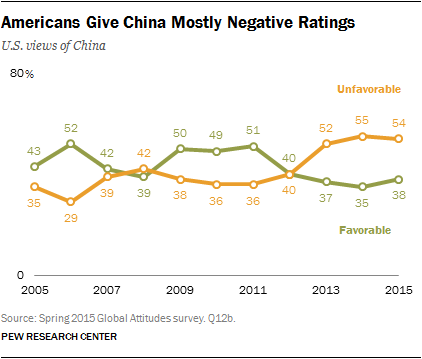
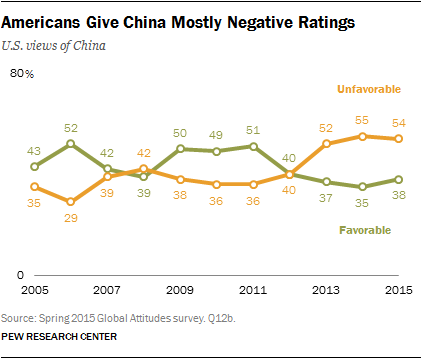
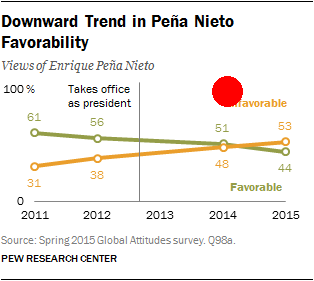
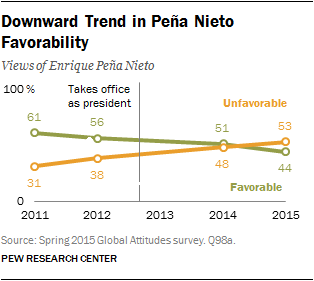
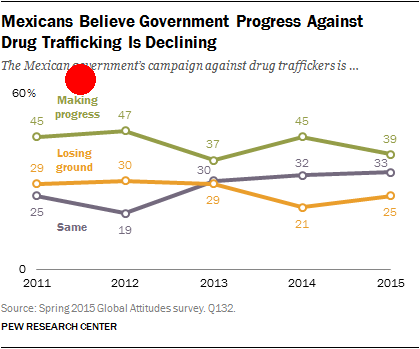
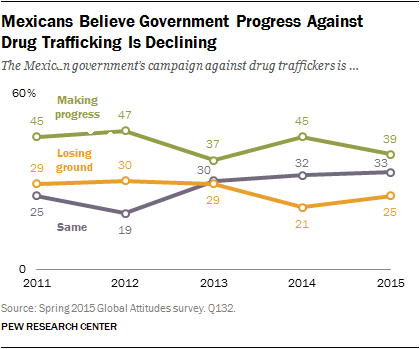
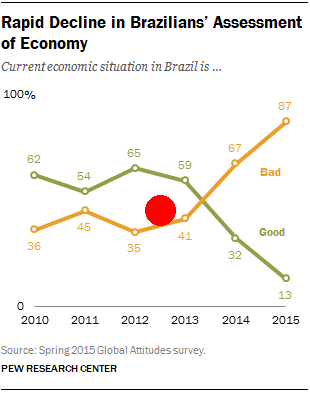
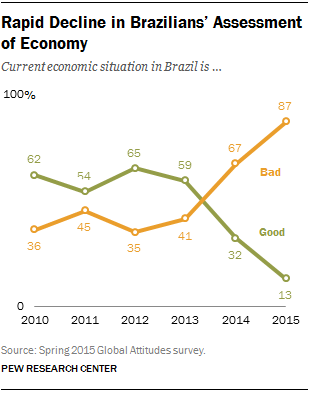
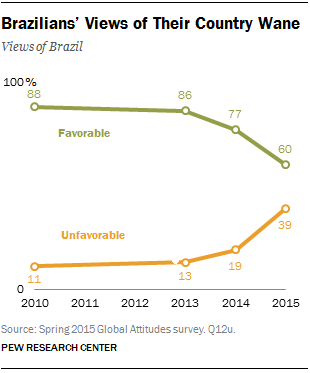
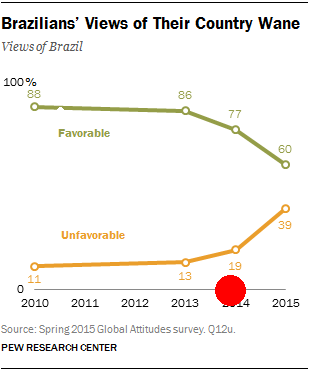
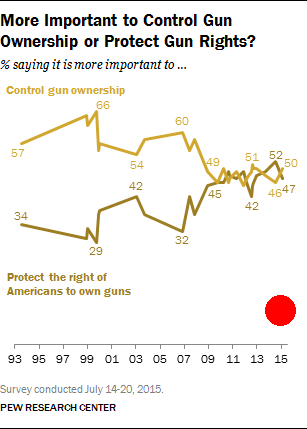
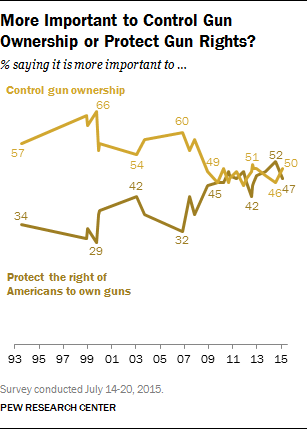
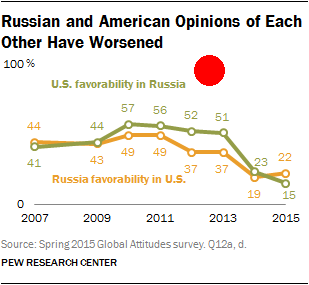
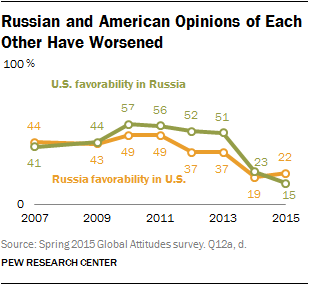
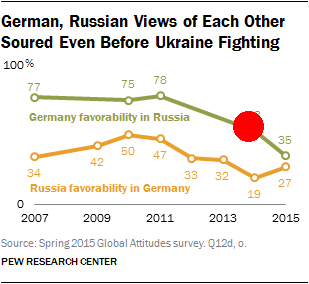
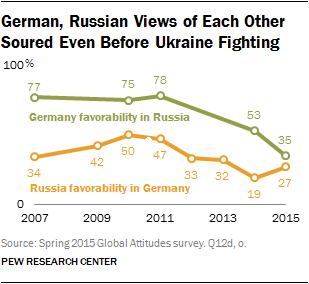
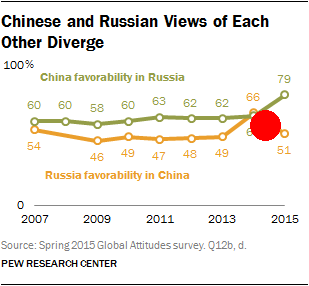
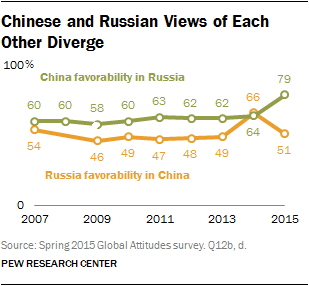
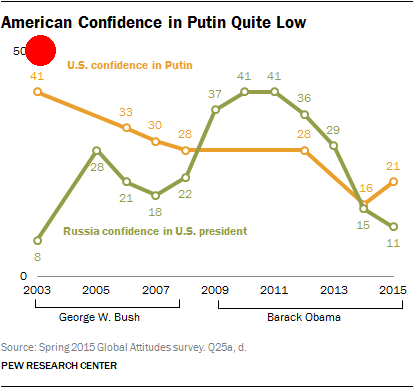
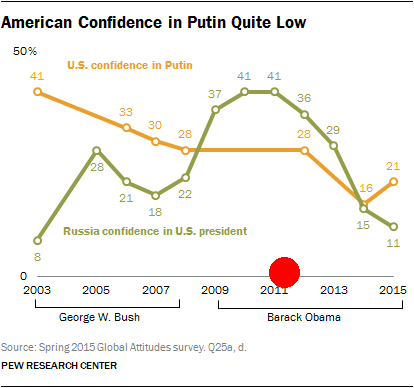

In [77]:
from PIL import Image, ImageDraw
import io
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import pandas as pd
import base64

def create_visualization_with_dots(dataset, results, num_samples):
    # Create a DataFrame to store the results
    data = []
    
    # Define min and max radius for dots
    MIN_RADIUS = 3
    MAX_RADIUS = 15
    
    for i in range(num_samples):
        row = dataset[i]
        img = Image.open(io.BytesIO(row['image']['bytes']))
        
        # Create a copy of the image to draw dots on
        img_with_dots = img.copy().convert('RGBA')  # Ensure RGBA mode for transparency
        draw = ImageDraw.Draw(img_with_dots)
        
        # Get the result data
        result = results[i]
        if result:  # Check if result exists
            # Draw dots for each coordinate
            for coord in result.coordinates:
                # Scale radius based on weight
                radius = MIN_RADIUS + (MAX_RADIUS - MIN_RADIUS) * coord.weight
                x, y = coord.x, coord.y
                
                # Convert weight (0-1) to RGBA alpha (0-255)
                alpha = int(coord.weight * 255)
                
                # Draw a red dot with size and opacity based on weight
                draw.ellipse(
                    [x-radius, y-radius, x+radius, y+radius],
                    fill=(255, 0, 0, alpha)
                )
        
        # Convert image to bytes for display
        buffered = io.BytesIO()
        img_with_dots.save(buffered, format="PNG")
        img_bytes = buffered.getvalue()
        
        # Add row to data
        data.append({
            'Image': img_bytes,
            'Question': row['query'],
            'Answer': row['label'][0] if isinstance(row['label'], list) else row['label'],
            'Model Answer': result.raw_answer if result else 'N/A'
        })
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Create HTML table
    html = '<table style="border-collapse: collapse; width: 100%;">'
    html += '<tr><th>Image</th><th>Question</th><th>Answer</th><th>Model Answer</th></tr>'
    
    for _, row in df.iterrows():
        html += '<tr style="border: 1px solid black;">'
        # Image cell
        img_b64 = base64.b64encode(row['Image']).decode()
        html += f'<td style="padding: 10px;"><img src="data:image/png;base64,{img_b64}" style="max-width: 300px;"/></td>'
        # Other cells
        html += f'<td style="padding: 10px;">{row["Question"]}</td>'
        html += f'<td style="padding: 10px;">{row["Answer"]}</td>'
        html += f'<td style="padding: 10px;">{row["Model Answer"]}</td>'
        html += '</tr>'
    
    html += '</table>'
    
    # Display the table
    display(HTML(html))

# Use the previous analysis results
create_visualization_with_dots(train_ds, results, 20)